## Problem Statement

A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure and ICP transformation. Due to noise in wheel odometry it generated a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

In [1]:
%matplotlib inline
from gtsam import *
import matplotlib.pyplot as plt
import math
import numpy as np
from gtsam.utils import plot as gtsam_plot
np.random.seed(4)

### Visualisation Utility
Drawing functions for plotting one, two and three trajectories simultaneously.

In [2]:
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'k-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'm->')

    plt.show()


def drawTwo(X1, Y1, THETA1, X2, Y2, THETA2):
    ax = plt.subplot(111)
    ax.plot(X1, Y1, 'ro', label='Ground Truth')
    plt.plot(X1, Y1, 'k-')

    for i in range(len(THETA1)):
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        plt.plot([X1[i], x2], [Y1[i], y2], 'r->')

    ax.plot(X2, Y2, 'bo', label='Optimized')
    plt.plot(X2, Y2, 'k-')

    for i in range(len(THETA2)):
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'b->')

    plt.legend()
    plt.show()


def drawThree(X1, Y1, THETA1, X2, Y2, THETA2, X3, Y3, THETA3):
    ax = plt.subplot(111)
    ax.plot(X1, Y1, 'ro', label='Ground Truth')
    plt.plot(X1, Y1, 'k-')

    for i in range(len(THETA1)):
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        plt.plot([X1[i], x2], [Y1[i], y2], 'r->')

    ax.plot(X2, Y2, 'bo', label='Optimized')
    plt.plot(X2, Y2, 'k-')

    for i in range(len(THETA2)):
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'b->')

    ax.plot(X3, Y3, 'go', label='Noisy')
    plt.plot(X3, Y3, 'k-')

    for i in range(len(THETA3)):
        x2 = 0.25*math.cos(THETA3[i]) + X3[i]
        y2 = 0.25*math.sin(THETA3[i]) + Y3[i]
        plt.plot([X3[i], x2], [Y3[i], y2], 'g->')

    plt.legend()
    plt.show()	


### Generating X, Y coordinates and $\theta$ separately for the trajectory

In [3]:
# function to generate the trajectory
def genTraj():
    init = (0, 0)

    # Forward I
    num = 20; xSt = -5; ySt = -8; leng = 9.0; step = float(leng)/num
    X1 = np.zeros(num); Y1 = np.zeros(num); X1[0] = xSt; Y1[0] = ySt
    for i in range(1, num):
        X1[i] = X1[i-1] + step
        Y1[i] = ySt

    # UTurn I
    rad = 2.5; num = 20
    xCen = X1[-1]; yCen = Y1[-1] + rad
    thetas = np.linspace(-math.pi/2, math.pi/2, num)
    X2 = np.zeros(num); Y2 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X2[i] = (xCen + rad*math.cos(theta))
        Y2[i] = (yCen + rad*math.sin(theta))

    # Backward I
    num = 20; leng = 10.0; step = float(leng)/num
    xSt = X2[-1]; ySt = Y2[-1]
    X3 = np.zeros(num); Y3 = np.zeros(num); X3[0] = xSt; Y3[0] = ySt 
    for i in range(1, num):
        X3[i] = X3[i-1] - step
        Y3[i] = ySt

    # UTurn II
    rad = 2.6; num = 20
    xCen = X3[-1]; yCen = Y3[-1] - rad
    thetas = np.linspace(math.pi/2, 3*math.pi/2, num)
    X4 = np.zeros(num); Y4 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X4[i] = (xCen + rad*math.cos(theta))
        Y4[i] = (yCen + rad*math.sin(theta))

    # Forward II
    num = 20; leng = 11.0; step = float(leng)/num
    xSt = X4[-1]; ySt = Y4[-1]
    X5 = np.zeros(num); Y5 = np.zeros(num); X5[0] = xSt; Y5[0] = ySt
    for i in range(1, num):
        X5[i] = X5[i-1] + step
        Y5[i] = ySt

    # UTurn III
    rad = 2.7; num = 20
    xCen = X5[-1]; yCen = Y5[-1] + rad
    thetas = np.linspace(-math.pi/2, math.pi/2, num)
    X6 = np.zeros(num); Y6 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X6[i] = (xCen + rad*math.cos(theta))
        Y6[i] = (yCen + rad*math.sin(theta))	

    # Assemble
    X = np.concatenate([X1, X2, X3, X4, X5, X6]); Y = np.concatenate([Y1, Y2, Y3, Y4, Y5, Y6])
    THETA = np.array(getTheta(X, Y))

    return (X, Y, THETA)

# function to get theta by taking the slope of the line joining the previous and next point
def getTheta(X ,Y):
    THETA = [None]*len(X)
    for i in range(1, len(X)-1):
        if(X[i+1] == X[i-1]):
            if (Y[i+1]>Y[i-1]):
                THETA[i] = math.pi/2
            else:
                THETA[i] = 3*math.pi/2
            continue

        THETA[i] = math.atan((Y[i+1]-Y[i-1])/(X[i+1]-X[i-1]))

        if(X[i+1]-X[i-1] < 0):
            THETA[i] += math.pi 

    if X[1]==X[0]:
        if Y[1] > Y[0]:
            THETA[0] = math.pi/2
        else:
            THETA[0] = 3*math.pi/2
    else:
        THETA[0] = math.atan((Y[1]-Y[0])/(X[1]-X[0]))

    if X[-1] == X[len(Y)-2]:
        if Y[1] > Y[0]:
            THETA[-1] = math.pi/2
        else:
            THETA[-1] = 3*math.pi/2
    else:
        THETA[-1] = math.atan((Y[-1]-Y[len(Y)-2])/(X[-1]-X[len(Y)-2]))

    return THETA

Ground Truth Trajectory

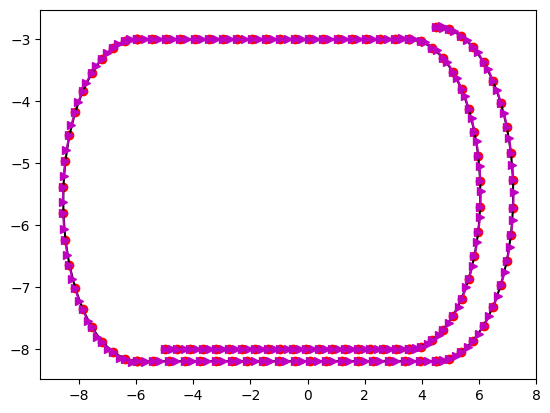

In [4]:
(X, Y, THETA) = genTraj()
draw(X, Y, THETA)

Adding noise to the trajectory to simulate real life scenario.  
We could not directly add noise values to $X, Y, \theta$ parameters. Instead noise should be added to the odometry values.  
T1_w = $T^w_1$ = 1 with respect to the world

In [5]:
def addNoise(X, Y, THETA):
    xN = np.zeros(len(X)); yN = np.zeros(len(Y)); tN = np.zeros(len(THETA))
    xN[0] = X[0]; yN[0] = Y[0]; tN[0] = THETA[0]

    for i in range(1, len(X)):
        # Get T2_1
        p1 = (X[i-1], Y[i-1], THETA[i-1])
        p2 = (X[i], Y[i], THETA[i])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = T2_1[0][2]
        del_y = T2_1[1][2]
        del_theta = math.atan2(T2_1[1, 0], T2_1[0, 0])

        # Add noise
        if(i<5):
            xNoise = 0; yNoise = 0; tNoise = 0
        else:
            xNoise = np.random.normal(0, 0.03); yNoise = np.random.normal(0, 0.03); tNoise = np.random.normal(0, 0.03)
        del_xN = del_x + xNoise; del_yN = del_y + yNoise; del_thetaN = del_theta + tNoise

        # Convert to T2_1'
        T2_1N = np.array([[math.cos(del_thetaN), -math.sin(del_thetaN), del_xN], [math.sin(del_thetaN), math.cos(del_thetaN), del_yN], [0, 0, 1]])

        # Get T2_w' = T1_w' . T2_1'
        p1 = (xN[i-1], yN[i-1], tN[i-1])
        T1_wN = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_wN = np.dot(T1_wN, T2_1N)

        # Get x2', y2', theta2'
        x2N = T2_wN[0][2]
        y2N = T2_wN[1][2]
        theta2N = math.atan2(T2_wN[1, 0], T2_wN[0, 0])

        xN[i] = x2N; yN[i] = y2N; tN[i] = theta2N  

    # tN = getTheta(xN, yN)

    return (xN, yN, tN)

Noisy trajectory

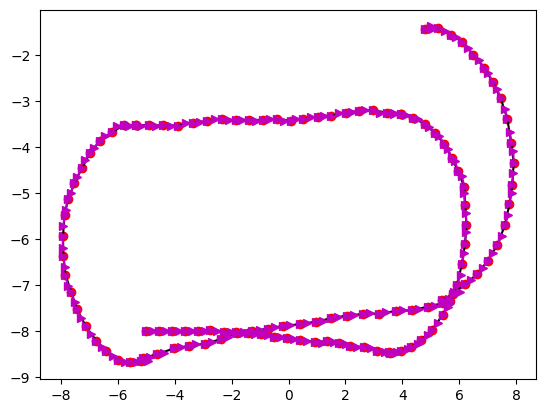

In [6]:
(xN, yN, tN) = addNoise(X, Y, THETA)
draw(xN, yN, tN)

Generating G2O file. We would be using `VERTEX_SE2` and `EDGE_SE2` for our task.  
Information matrix for odometry edges, $\omega_{odom}$ = `500.0 0.0 0.0 500.0 0.0 500.0`   
Information matrix for loop closure edges, $\omega_{lc}$ = `700.0 0.0 0.0 700.0 0.0 700.0`  
Loop closure constraints are generated for the starting part of the trajectory. In practice, they would be detected by loop closure system using bag of visual words and transformation would be calculated using ICP.  
Fix the starting node in pose graph otherwise the optimized pose graph can occur anywhere on cartesian plane.  
Below figure is generated using `g2o_viewer`, in terminal after generating `noise.g2o`, run: `g2o_viewer noise.g2o`  
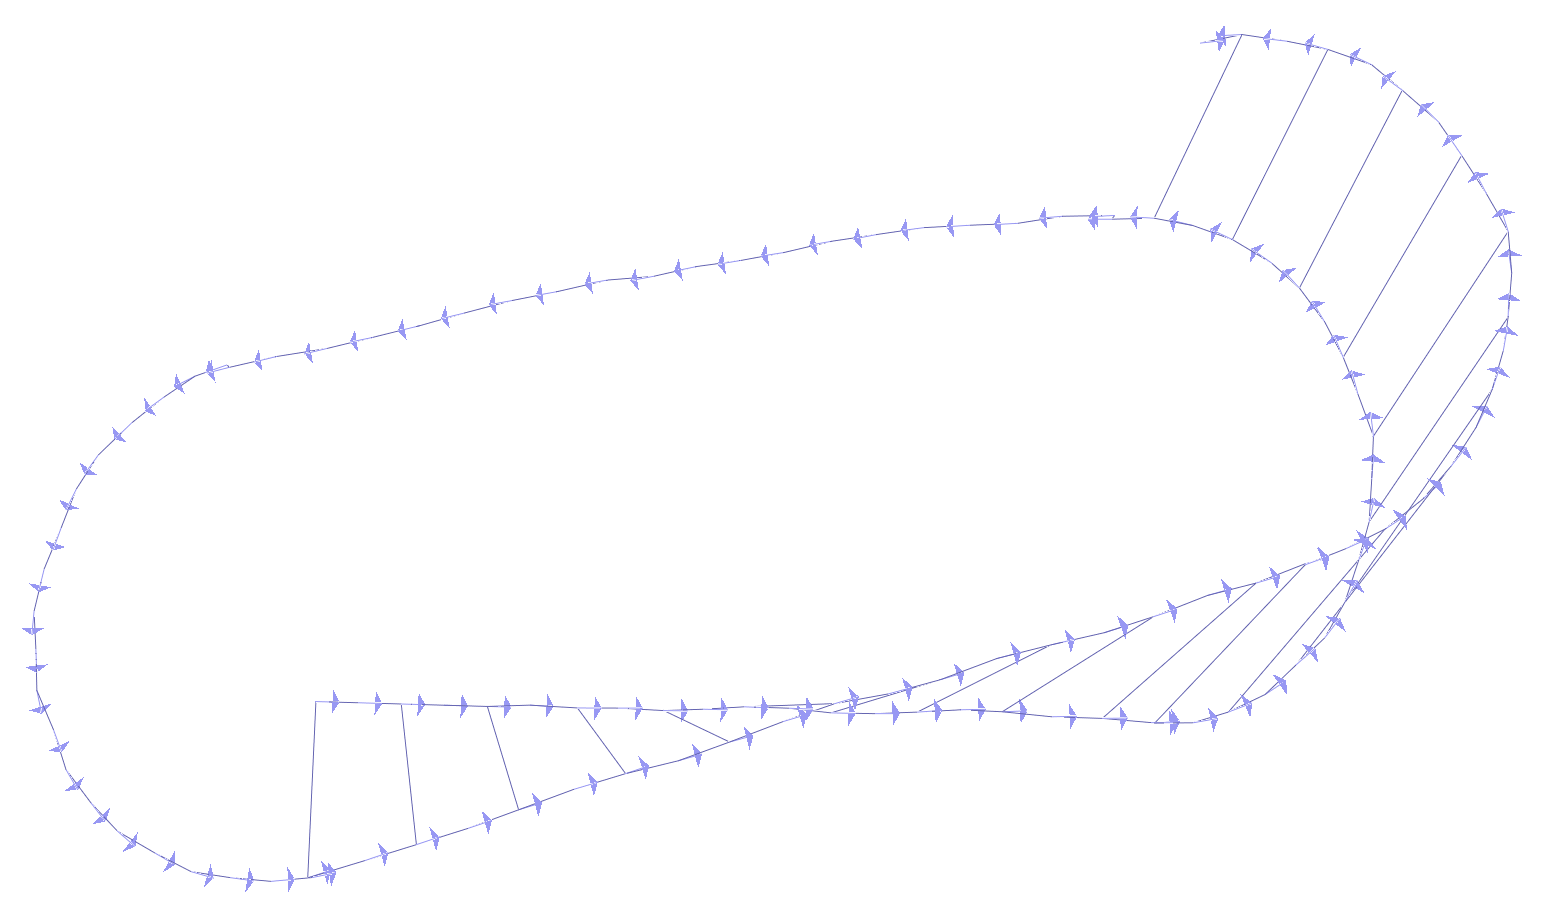



In [7]:
graph = NonlinearFactorGraph()
initial = Values()

def writeOdomToGtsam(X, Y, THETA, graph, values):
    graph.add(PriorFactorPose2(0, Pose2(X[0], Y[0], THETA[0]), noiseModel.Diagonal.Sigmas(np.array([0.000000001, 0.0000000001, 0.000000000001]))))
    values.insert(0, Pose2(X[0], Y[0], THETA[0]))
    pose = Pose2(X[0], Y[0], THETA[0])
    for i, (x, y, theta) in enumerate(zip(X,Y,THETA)):
        if i > 0:
            pose_prev = pose
            pose = Pose2(x, y, theta)
            graph.add(BetweenFactorPose2(i-1, i, pose_prev.inverse()*pose, noiseModel.Diagonal.Sigmas(np.array([0.0044, 0.0044, 0.0044]))))
            values.insert(i, Pose2(x, y, theta))
        # print(i, i+1, x, y, theta)

def writeLooptoGtsam(X, Y, THETA, graph, values):
    s2 = X.size
    pairs = []
    for i in range(0, 40, 2):
        pairs.append((i, i+80))
    
    for p in pairs:
        p1 = (X[p[0]], Y[p[0]], THETA[p[0]])
        p2 = (X[p[1]], Y[p[1]], THETA[p[1]])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = T2_1[0][2]
        del_y = T2_1[1][2]
        del_theta = math.atan2(T2_1[1, 0], T2_1[0, 0])

        graph.add(BetweenFactorPose2(p[0], p[1], Pose2(del_x, del_y, del_theta), noiseModel.Diagonal.Sigmas(np.array([0.0137, 0.0137, 0.0137]))))
        # print(p[0], p[1], del_x, del_y, del_theta)

In [8]:
writeOdomToGtsam(xN, yN, tN, graph=graph, values=initial)
marginals_without_loop = Marginals(graph, initial)
writeLooptoGtsam(X, Y, THETA, graph=graph, values=initial)

#optimize
from gtsam import LevenbergMarquardtOptimizer
params = LevenbergMarquardtParams()
params.setVerbosity('ERROR')
optimizer = LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()


Initial error: 128148
newError: 3251.64
errorThreshold: 3251.64 > 0
absoluteDecrease: 124896.729352 >= 1e-05
relativeDecrease: 0.97462598579 >= 1e-05
newError: 390.504656099
errorThreshold: 390.504656099 > 0
absoluteDecrease: 2861.13385094 >= 1e-05
relativeDecrease: 0.879905267681 >= 1e-05
newError: 386.541837999
errorThreshold: 386.541837999 > 0
absoluteDecrease: 3.96281809988 >= 1e-05
relativeDecrease: 0.0101479407172 >= 1e-05
newError: 386.531377004
errorThreshold: 386.531377004 > 0
absoluteDecrease: 0.0104609951775 >= 1e-05
relativeDecrease: 2.7063034707e-05 >= 1e-05
newError: 386.530888876
errorThreshold: 386.530888876 > 0
absoluteDecrease: 0.000488128037546 >= 1e-05
relativeDecrease: 1.26284194916e-06 < 1e-05
converged
errorThreshold: 386.530888876 <? 0
absoluteDecrease: 0.000488128037546 <? 1e-05
relativeDecrease: 1.26284194916e-06 <? 1e-05
iterations: 5 >? 100


In [9]:
graph.print("Factor Graph:\n")

Factor Graph:
size: 140

Factor 0: PriorFactor on 0
  prior mean:  (-5, -8, 0)
  noise model: constrained sigmas [1e-09; 1e-10; 1e-12];
  noise model: constrained mu [1000; 1000; 1000];

Factor 1: BetweenFactor(0,1)
  measured:  (0.45, 0, 0)
isotropic dim=3 sigma=0.0044

Factor 2: BetweenFactor(1,2)
  measured:  (0.45, 0, 0)
isotropic dim=3 sigma=0.0044

Factor 3: BetweenFactor(2,3)
  measured:  (0.45, 0, 0)
isotropic dim=3 sigma=0.0044

Factor 4: BetweenFactor(3,4)
  measured:  (0.45, 0, 0)
isotropic dim=3 sigma=0.0044

Factor 5: BetweenFactor(4,5)
  measured:  (0.451516851, 0.01499854, -0.0298772679)
isotropic dim=3 sigma=0.0044

Factor 6: BetweenFactor(5,6)
  measured:  (0.470807955, -0.0125490456, -0.0475373171)
isotropic dim=3 sigma=0.0044

Factor 7: BetweenFactor(6,7)
  measured:  (0.430568797, 0.0179572552, 0.00996750098)
isotropic dim=3 sigma=0.0044

Factor 8: BetweenFactor(7,8)
  measured:  (0.415575701, 0.0185600907, -0.00263960785)
isotropic dim=3 sigma=0.0044

Factor 9: Bet

In [10]:
initial.print("Initial Estimate:\n")

Initial Estimate:

Values with 120 values:
Value 0: (gtsam::Pose2)
(-5, -8, 0)

Value 1: (gtsam::Pose2)
(-4.55, -8, 0)

Value 2: (gtsam::Pose2)
(-4.1, -8, 0)

Value 3: (gtsam::Pose2)
(-3.65, -8, 0)

Value 4: (gtsam::Pose2)
(-3.2, -8, 0)

Value 5: (gtsam::Pose2)
(-2.74848315, -7.98500146, -0.0298772679)

Value 6: (gtsam::Pose2)
(-2.27826019, -8.01160927, -0.077414585)

Value 7: (gtsam::Pose2)
(-1.84759218, -8.02700482, -0.067447084)

Value 8: (gtsam::Pose2)
(-1.4317105, -8.03649505, -0.0700866919)

Value 9: (gtsam::Pose2)
(-0.969396391, -8.05895815, -0.10479118)

Value 10: (gtsam::Pose2)
(-0.51329715, -8.12523609, -0.0583817998)

Value 11: (gtsam::Pose2)
(-0.0423197944, -8.15137745, -0.0878715494)

Value 12: (gtsam::Pose2)
(0.407991647, -8.18623381, -0.124139994)

Value 13: (gtsam::Pose2)
(0.922180859, -8.23847459, -0.0733692627)

Value 14: (gtsam::Pose2)
(1.34127284, -8.22007355, -0.11419823)

Value 15: (gtsam::Pose2)
(1.7707866, -8.25295737, -0.112758043)

Value 16: (gtsam::Pose2)
(2.

In [11]:
result.print("Result:\n")

Result:

Values with 120 values:
Value 0: (gtsam::Pose2)
(-5, -8, 6.30433605e-36)

Value 1: (gtsam::Pose2)
(-4.54868009, -7.99833721, 0.000910991209)

Value 2: (gtsam::Pose2)
(-4.09736161, -7.99626349, 0.00107372774)

Value 3: (gtsam::Pose2)
(-3.64600033, -7.99761368, 0.00366244327)

Value 4: (gtsam::Pose2)
(-3.19464332, -7.99780007, 0.00707681159)

Value 5: (gtsam::Pose2)
(-2.73948036, -7.97983811, -0.0211718037)

Value 6: (gtsam::Pose2)
(-2.26528003, -8.00258301, -0.0670592183)

Value 7: (gtsam::Pose2)
(-1.82970101, -8.01584261, -0.0552010389)

Value 8: (gtsam::Pose2)
(-1.4089618, -8.02256837, -0.0550078948)

Value 9: (gtsam::Pose2)
(-0.943197679, -8.03905694, -0.0904537955)

Value 10: (gtsam::Pose2)
(-0.483031496, -8.09978878, -0.0445171911)

Value 11: (gtsam::Pose2)
(-0.00872590098, -8.12003399, -0.0725295265)

Value 12: (gtsam::Pose2)
(0.445078241, -8.14861451, -0.107120007)

Value 13: (gtsam::Pose2)
(0.963671684, -8.19508483, -0.056710861)

Value 14: (gtsam::Pose2)
(1.38598459, -

In [12]:
X_gtsam_opt = []
Y_gtsam_opt = []
THETA_gtsam_opt = []

## Alternate Way
# for key in result.keys():
#     # print(key, result.atPose2(key).x(), result.atPose2(key).y(), result.atPose2(key).theta())
#     X_gtsam_opt.append(result.atPose2(key).x())
#     Y_gtsam_opt.append(result.atPose2(key).y())
#     THETA_gtsam_opt.append(result.atPose2(key).theta())

arr_opt = gtsam.utilities.extractPose2(result)
for opt_mes in arr_opt:
    X_gtsam_opt.append(opt_mes[0])
    Y_gtsam_opt.append(opt_mes[1])
    THETA_gtsam_opt.append(opt_mes[2])
    
print(len(X_gtsam_opt))

120


Optimize the pose graph using g2o binary and loads the optimized graph.  
G2O provides options to change the number of iteration steps, change the optimization solver and incorporate robust cost functions to minimize the impact of false loop closure constraints due to error in frontend.  

Comparing Ground Truth and optimized trajectory.  

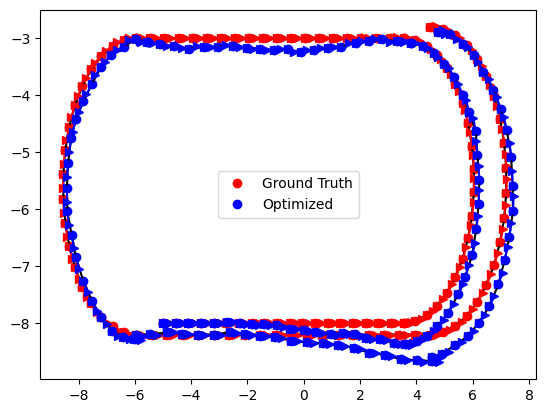

In [14]:
# optimize()
# (xOpt, yOpt, tOpt) = readG2o("opt.g2o")
drawTwo(X, Y, THETA, X_gtsam_opt, Y_gtsam_opt, THETA_gtsam_opt)

Comparing Ground Truth, optimized and noisy trajectory.  

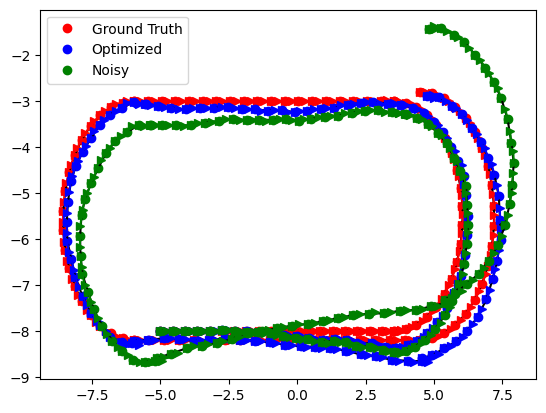

In [15]:
drawThree(X, Y, THETA, X_gtsam_opt, Y_gtsam_opt, THETA_gtsam_opt, xN, yN, tN)

In [16]:
writeG2o(graph, initial, "graph.g2o")

In [17]:
print(readG2o(filename="graph.g2o"))

(NonlinearFactorGraph: size: 139

Factor 0: BetweenFactor(0,1)
  measured:  (0.45, 0, 0)
isotropic dim=3 sigma=0.00439999968

Factor 1: BetweenFactor(1,2)
  measured:  (0.45, 0, 0)
isotropic dim=3 sigma=0.00439999968

Factor 2: BetweenFactor(2,3)
  measured:  (0.45, 0, 0)
isotropic dim=3 sigma=0.00439999968

Factor 3: BetweenFactor(3,4)
  measured:  (0.45, 0, 0)
isotropic dim=3 sigma=0.00439999968

Factor 4: BetweenFactor(4,5)
  measured:  (0.451517, 0.0149985, -0.0298773)
isotropic dim=3 sigma=0.00439999968

Factor 5: BetweenFactor(5,6)
  measured:  (0.470808, -0.012549, -0.0475373)
isotropic dim=3 sigma=0.00439999968

Factor 6: BetweenFactor(6,7)
  measured:  (0.430569, 0.0179573, 0.0099675)
isotropic dim=3 sigma=0.00439999968

Factor 7: BetweenFactor(7,8)
  measured:  (0.415576, 0.0185601, -0.00263961)
isotropic dim=3 sigma=0.00439999968

Factor 8: BetweenFactor(8,9)
  measured:  (0.462752, 0.00996759, -0.0347045)
isotropic dim=3 sigma=0.00439999968

Factor 9: BetweenFactor(9,10)
  

Information Matrix from NoiseModels

In [18]:
print(noiseModel.Diagonal.Sigmas(np.array([0.1, 1.0, 0.0])).information())

[[100.   0.   0.]
 [  0.   1.   0.]
 [  0.   0.   0.]]


128148.36785865757
386.5308888762148


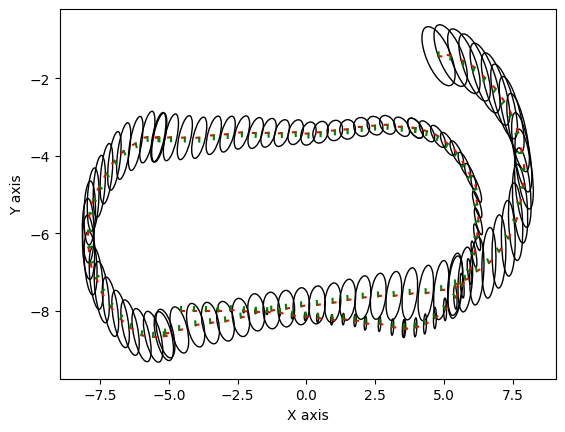

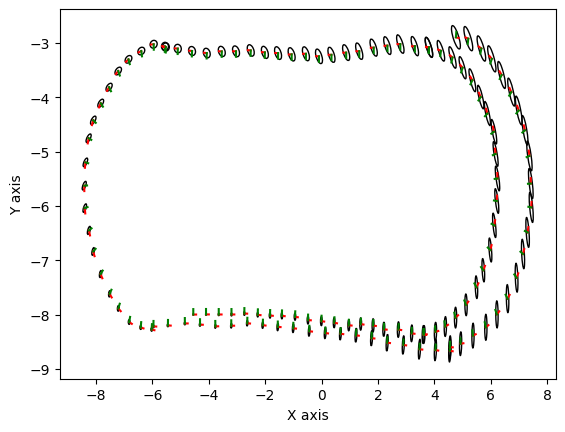

In [19]:
marginals_with_loop = gtsam.Marginals(graph, initial)
# print(marginals_with_loop.marginalCovariance(1))
print(graph.error(initial))
print(graph.error(result))

for i in range(1, 120):
    gtsam_plot.plot_pose2(0, initial.atPose2(i), 0.1, marginals_without_loop.marginalCovariance(i))
for i in range(1, 120):
    gtsam_plot.plot_pose2(1, result.atPose2(i), 0.1, marginals_with_loop.marginalCovariance(i))
# dir(marginals.marginalCovariance)